In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("final_df.csv")
df = df.iloc[:,1:]
y = df.churn
x = df.drop("churn",axis=1)

In [5]:
min_max = MinMaxScaler()
df2 = pd.DataFrame(min_max.fit_transform(x),columns=x.columns)

In [6]:
df2.head()

,seniorcitizen,tenure,monthlycharges,totalcharges,gender_Female,gender_Male,partner_No,partner_Yes,dependents_No,dependents_Yes,...,streamingmovies_Yes,contract_Month-to-month,contract_One year,contract_Two year,paperlessbilling_No,paperlessbilling_Yes,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
0,0.0,0.013889,0.115423,0.003437,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.472222,0.385075,0.217564,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.027778,0.354229,0.012453,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.625000,0.239303,0.211951,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.027778,0.521891,0.017462,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [7]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=33)

In [8]:
bagged_tree = BaggingClassifier(DecisionTreeClassifier("gini",max_depth=5),n_estimators = 20)
bagged_tree.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),
                  n_estimators=20)

In [9]:
bagged_tree.score(X_train, y_train)

0.808595229079894

In [10]:
bagged_tree.score(X_test, y_test)

0.7932992617830777

In [12]:
dt = DecisionTreeClassifier(
                            criterion = 'entropy',
                            max_depth = 6,
                            min_samples_leaf = 1,
                            min_samples_split = 30,
                            random_state = 33)

bc_param_grid = {
    'bootstrap':[True, False],
    'bootstrap_features':[True, False],
    'n_estimators':[1,5,10,15,20,25],
    'max_samples':[0.2,0.4,0.6,0.8,1.0]
}

grid_search = GridSearchCV(BaggingClassifier(dt), param_grid = bc_param_grid, cv = 4, verbose = True)
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 120 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:   55.0s finished


GridSearchCV(cv=4,
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                                               max_depth=6,
                                                                               min_samples_split=30,
                                                                               random_state=33)),
             param_grid={'bootstrap': [True, False],
                         'bootstrap_features': [True, False],
                         'max_samples': [0.2, 0.4, 0.6, 0.8, 1.0],
                         'n_estimators': [1, 5, 10, 15, 20, 25]},
             verbose=True)

In [13]:
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Parameters: {'bootstrap': True, 'bootstrap_features': True, 'max_samples': 0.2, 'n_estimators': 25}
Best Score: 0.8063229761658982


In [14]:
test_preds = grid_search.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, test_preds)
roc_auc = auc(fpr, tpr)

In [15]:
print(f"Precision Score: {precision_score(y_test, test_preds)}")
print(f"Recall Score: {recall_score(y_test, test_preds)}")
print(f"Accuracy Score: {accuracy_score(y_test, test_preds)}")
print(f"F1 Score: {f1_score(y_test, test_preds)}")

Precision Score: 0.6703910614525139
Recall Score: 0.5
Accuracy Score: 0.7967064168086314
F1 Score: 0.5727923627684964


In [16]:
def viz_roc(fpr, tpr, roc_auc, string):
    
    plt.style.use('ggplot')
    plt.figure(figsize = (10, 10))
    plt.plot(fpr, tpr, lw = 2, label = f"{string} AUC = "+str(roc_auc))
    plt.plot([0,1], [0,1], lw = 2, ls = '--')
    plt.xlim([0,1])
    plt.ylim([0,1.05])
    plt.xlabel('False Positive Rate', fontweight = 'bold', fontsize = 20)
    plt.ylabel('True Positive Rate', fontweight = 'bold', fontsize = 20)
    plt.title(f'ROC Curve: {string}', fontsize = 25, fontweight = 'bold')
    plt.legend(loc = 4, fontsize =15)
    plt.tight_layout()

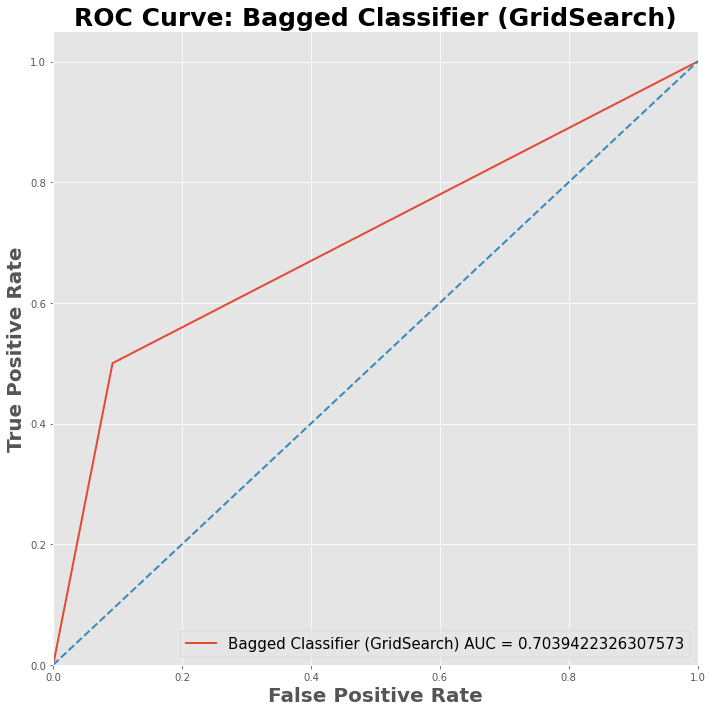

In [17]:
viz_roc(fpr, tpr, roc_auc, 'Bagged Classifier (GridSearch)')

In [18]:
pd.crosstab(y_test, test_preds, rownames = ['True'], colnames = ['Predicted'], margins = True)

Predicted,0,1,All
True,,,
0,1163,118,1281
1,240,240,480
All,1403,358,1761


In [19]:
report1 = pd.DataFrame(classification_report(y_test, test_preds, output_dict = True)).transpose()
report1

,precision,recall,f1-score,support
0,0.828938,0.907884,0.866617,1281.000000
1,0.670391,0.500000,0.572792,480.000000
accuracy,0.796706,0.796706,0.796706,0.796706
macro avg,0.749665,0.703942,0.719705,1761.000000
weighted avg,0.785722,0.796706,0.786529,1761.000000


## Random forest

In [21]:
rf = RandomForestClassifier(random_state = 33)
rf.fit(X_train, y_train)
test_preds = rf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, test_preds)
roc_auc = auc(fpr, tpr)

In [22]:
print(f"Precision Score: {precision_score(y_test, test_preds)}")
print(f"Recall Score: {recall_score(y_test, test_preds)}")
print(f"Accuracy Score: {accuracy_score(y_test, test_preds)}")
print(f"F1 Score: {f1_score(y_test, test_preds)}")

Precision Score: 0.6505376344086021
Recall Score: 0.5041666666666667
Accuracy Score: 0.7910278250993753
F1 Score: 0.568075117370892


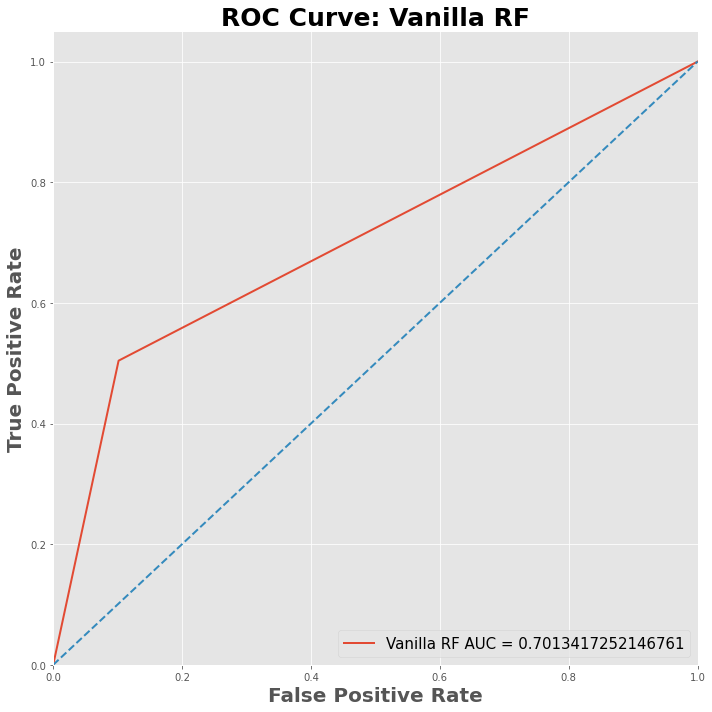

In [23]:
viz_roc(fpr, tpr, roc_auc, 'Vanilla RF')

In [24]:
pd.crosstab(y_test, test_preds, rownames = ['True'], colnames = ['Predicted'], margins = True)

Predicted,0,1,All
True,,,
0,1151,130,1281
1,238,242,480
All,1389,372,1761


In [25]:
report2 = pd.DataFrame(classification_report(y_test, test_preds, output_dict = True)).transpose()
report2

,precision,recall,f1-score,support
0,0.828654,0.898517,0.862172,1281.000000
1,0.650538,0.504167,0.568075,480.000000
accuracy,0.791028,0.791028,0.791028,0.791028
macro avg,0.739596,0.701342,0.715124,1761.000000
weighted avg,0.780104,0.791028,0.782010,1761.000000


In [26]:
param_grid = {
            'n_estimators': [20,22,25],
            'max_features': ['auto'],
            'max_depth': [8,10,12],
            'min_samples_split' : [20,25,30],
            'min_samples_leaf' : [1, 2, 3],
            'bootstrap':[True]
}

In [27]:
gs_rf = GridSearchCV(RandomForestClassifier(), param_grid, cv = 4, verbose = True)
gs_rf.fit(X_train, y_train)

Fitting 4 folds for each of 81 candidates, totalling 324 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:   21.6s finished


GridSearchCV(cv=4, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [8, 10, 12],
                         'max_features': ['auto'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [20, 25, 30],
                         'n_estimators': [20, 22, 25]},
             verbose=True)

In [28]:
test_preds = gs_rf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, test_preds)
roc_auc = auc(fpr, tpr)

In [29]:
gs_rf.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 30,
 'n_estimators': 25}

In [30]:
gs_rf.best_score_

0.8049970752184984

In [31]:
print(f"Precision Score: {precision_score(y_test, test_preds)}")
print(f"Recall Score: {recall_score(y_test, test_preds)}")
print(f"Accuracy Score: {accuracy_score(y_test, test_preds)}")
print(f"F1 Score: {f1_score(y_test, test_preds)}")

Precision Score: 0.6875
Recall Score: 0.5041666666666667
Accuracy Score: 0.8023850085178875
F1 Score: 0.5817307692307693


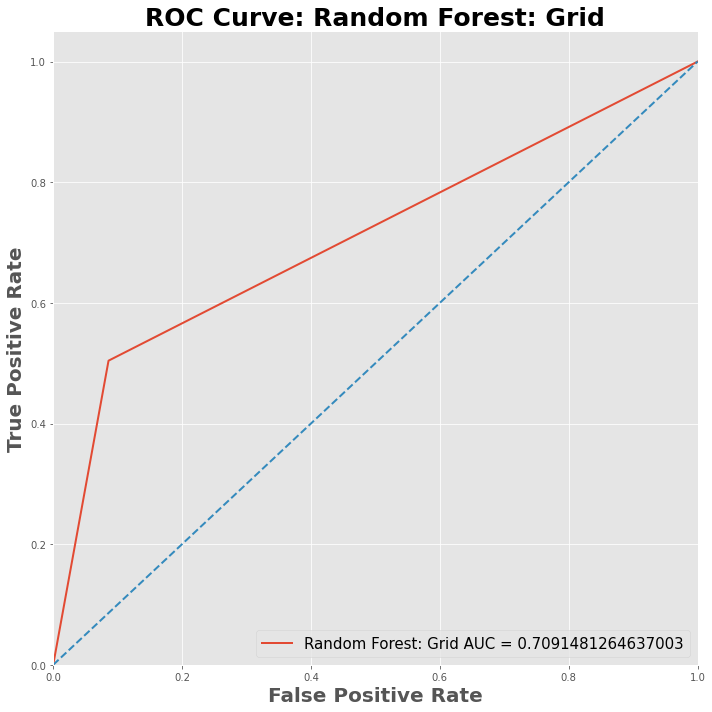

In [32]:
viz_roc(fpr, tpr, roc_auc, 'Random Forest: Grid')

In [33]:
pd.crosstab(y_test, test_preds, rownames = ['True'], colnames = ['Predicted'], margins = True)

Predicted,0,1,All
True,,,
0,1171,110,1281
1,238,242,480
All,1409,352,1761


In [34]:
report3 = pd.DataFrame(classification_report(y_test, test_preds, output_dict = True)).transpose()
report3

,precision,recall,f1-score,support
0,0.831086,0.914130,0.870632,1281.000000
1,0.687500,0.504167,0.581731,480.000000
accuracy,0.802385,0.802385,0.802385,0.802385
macro avg,0.759293,0.709148,0.726181,1761.000000
weighted avg,0.791948,0.802385,0.791885,1761.000000


In [35]:
report1, report2, report3

(              precision    recall  f1-score      support
 0              0.828938  0.907884  0.866617  1281.000000
 1              0.670391  0.500000  0.572792   480.000000
 accuracy       0.796706  0.796706  0.796706     0.796706
 macro avg      0.749665  0.703942  0.719705  1761.000000
 weighted avg   0.785722  0.796706  0.786529  1761.000000,
               precision    recall  f1-score      support
 0              0.828654  0.898517  0.862172  1281.000000
 1              0.650538  0.504167  0.568075   480.000000
 accuracy       0.791028  0.791028  0.791028     0.791028
 macro avg      0.739596  0.701342  0.715124  1761.000000
 weighted avg   0.780104  0.791028  0.782010  1761.000000,
               precision    recall  f1-score      support
 0              0.831086  0.914130  0.870632  1281.000000
 1              0.687500  0.504167  0.581731   480.000000
 accuracy       0.802385  0.802385  0.802385     0.802385
 macro avg      0.759293  0.709148  0.726181  1761.000000
 weighted av